In [1]:
import pandas as pd
import numpy as np
import warnings
from pandas_profiling import ProfileReport
import sys

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sktime.utils.plotting import plot_series, plot_lags, plot_correlations
#from visuals import *

#config to clean up the notebook
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')


In [2]:
#read the training data and parse the dates into a datetime object
df = pd.read_csv(
        'train.csv',
        usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
        dtype={
            'store_nbr' : 'category',
            'family' : 'category',
            'sales' : 'float32',
        },
        parse_dates=['date'],
        infer_datetime_format=True,
)

#convert the date into a period 
df['date'] = df.date.dt.to_period('D')

#set a multiindex and sort to clean up the display of dataframe
df = df.set_index(['store_nbr', 'family', 'date']).sort_index()
df.head()

sales  onpromotion
store_nbr family     date                          
1         AUTOMOTIVE 2013-01-01   0.00            0
                     2013-01-02   2.00            0
                     2013-01-03   3.00            0
                     2013-01-04   3.00            0
                     2013-01-05   5.00            0

In [3]:
#aggregate the stores daily sales by product family
df_family = (
    df.groupby(['family', 'date']).mean().unstack('family')
)
display(df_family.head())
df_family.shape

sales                                                \
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2013-01-01       0.00      0.00   0.04     15.00  0.00         3.34   
2013-01-02       4.72      0.00   3.83   1335.04  0.00       486.04   
2013-01-03       2.98      0.00   2.31    964.91  0.00       341.79   
2013-01-04       3.13      0.00   2.46   1003.09  0.00       309.67   
2013-01-05       6.33      0.00   3.54   1441.07  0.00       414.22   

                                                                             \
family     CELEBRATION CLEANING  DAIRY   DELI   EGGS FROZEN FOODS GROCERY I   
date                                                                          
2013-01-01        0.00     3.44   2.65   1.32   0.85         0.55     12.96   
2013-01-02        0.00  1382.02 432.98 291.75 202.44       131.77   3741.11   
2013-01-03        0.00  1035.06 333.35 206.90 136.26        88.16   2682.93   
2013-01-04        0.00   964.15 336.07 187.84 125.19        83.81   2513.96   
2013-01-05        0.00  1298.67 427.44 254.35 158.81       107.07   3488.07   

                                                                       \
family     GROCERY II HARDWARE HOME AND KITCHEN I HOME AND KITCHEN II   
date                                                                    
2013-01-01       0.28     0.00               0.00                0.00   
2013-01-02      27.33     0.85               0.00                0.00   
2013-01-03      19.41     0.69               0.00                0.00   
2013-01-04      19.09     1.06               0.00                0.00   
2013-01-05      23.57     1.61               0.00                0.00   

                                                                          \
family     HOME APPLIANCES HOME CARE LADIESWEAR LAWN AND GARDEN LINGERIE   
date                                                                       
2013-01-01            0.00      0.00       0.00            0.04     0.09   
2013-01-02            0.39      0.00       0.00            2.24     8.69   
2013-01-03            0.28      0.00       0.00            1.54     6.78   
2013-01-04            0.24      0.00       0.00            2.35     7.07   
2013-01-05            0.20      0.00       0.00            3.33     8.48   

                                                                         \
family     LIQUOR,WINE,BEER MAGAZINES  MEATS PERSONAL CARE PET SUPPLIES   
date                                                                      
2013-01-01             1.94      0.00   2.05          0.46         0.00   
2013-01-02            44.65      0.00 386.51        318.59         0.00   
2013-01-03            45.85      0.00 307.36        232.74         0.00   
2013-01-04            88.81      0.00 400.48        209.31         0.00   
2013-01-05           124.35      0.00 386.65        311.46         0.00   

                                                                   \
family     PLAYERS AND ELECTRONICS POULTRY PREPARED FOODS PRODUCE   
date                                                                
2013-01-01                    0.00    0.79           0.70    0.00   
2013-01-02                    0.00  258.81          98.85    0.00   
2013-01-03                    0.00  197.67          66.51    0.00   
2013-01-04                    0.00  199.49          82.83    0.00   
2013-01-05                    0.00  249.54         107.96    0.00   

                                              onpromotion                   \
family     SCHOOL AND OFFICE SUPPLIES SEAFOOD  AUTOMOTIVE BABY CARE BEAUTY   
date                                                                         
2013-01-01                       0.00    0.00        0.00      0.00   0.00   
2013-01-02                       0.00   28.27        0.00      0.00   0.00   
2013-01-03                       0.00   20.27        0.00      0.00   0.00  

(1684, 66)

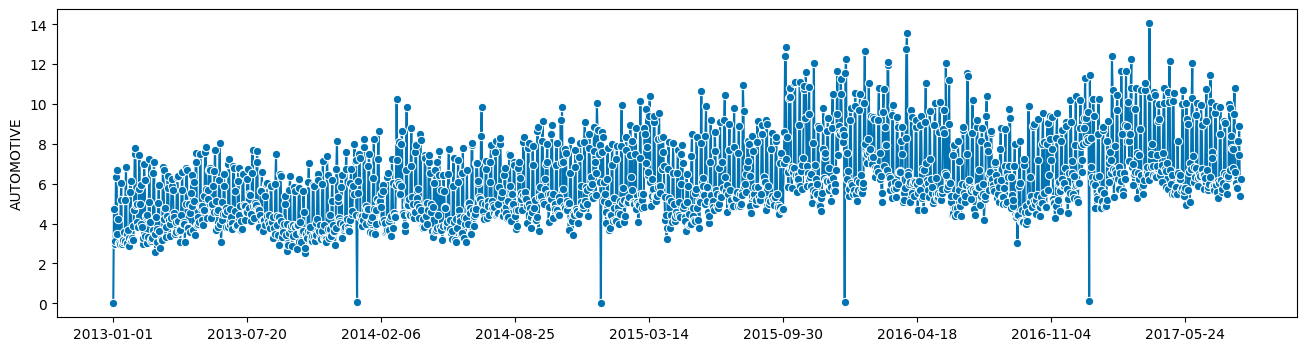

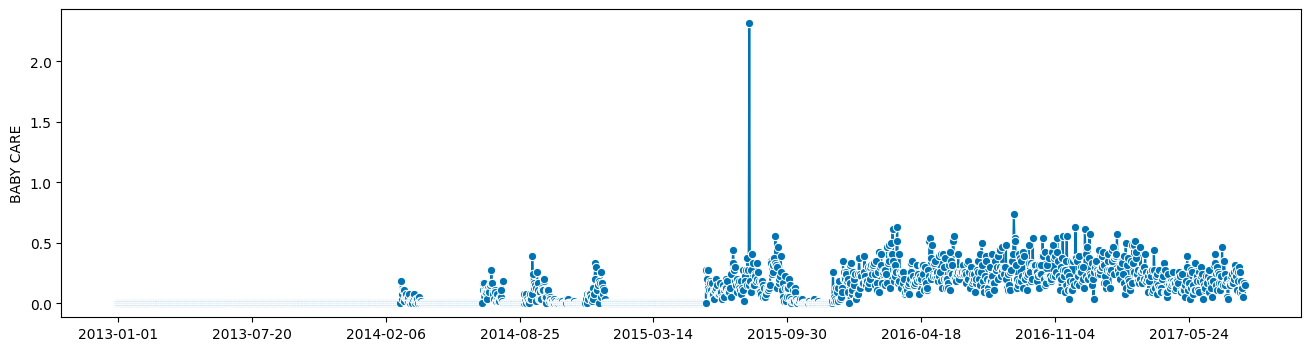

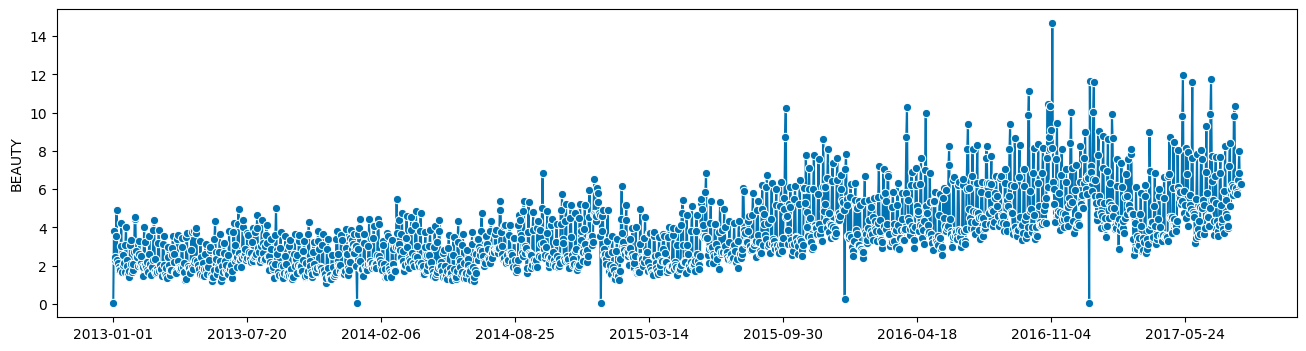

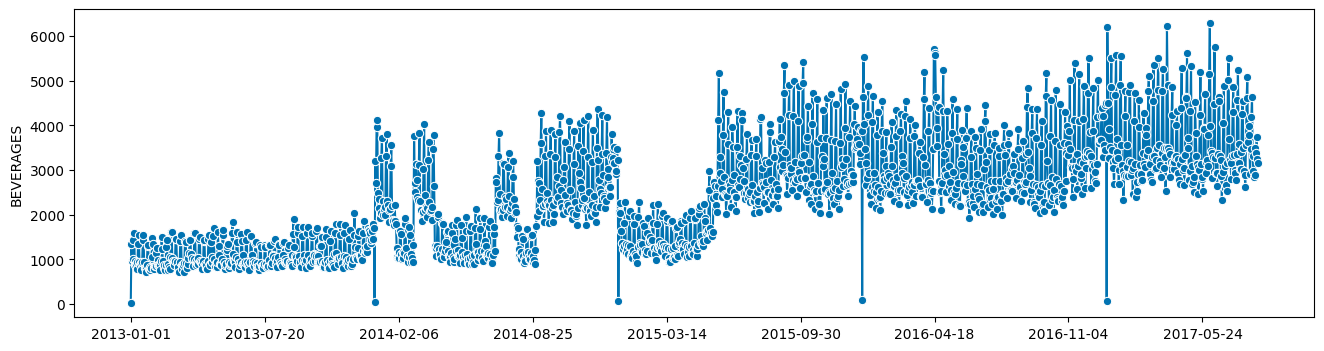

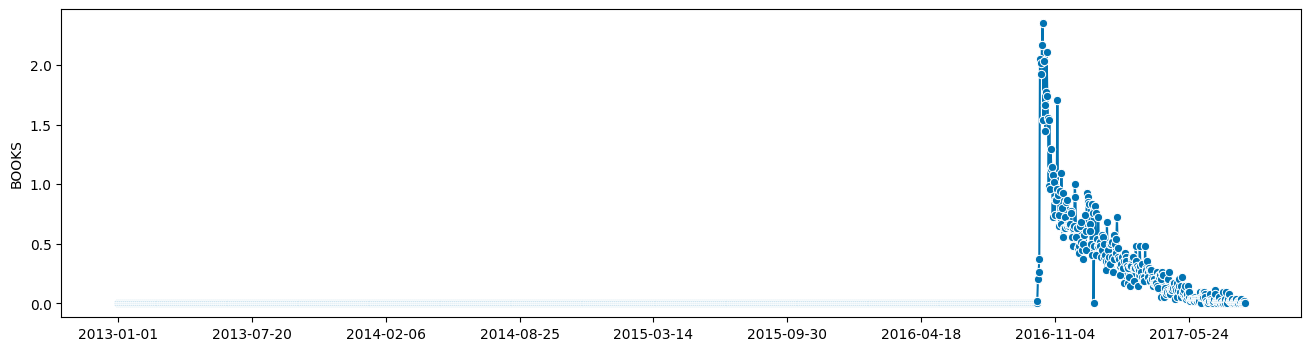

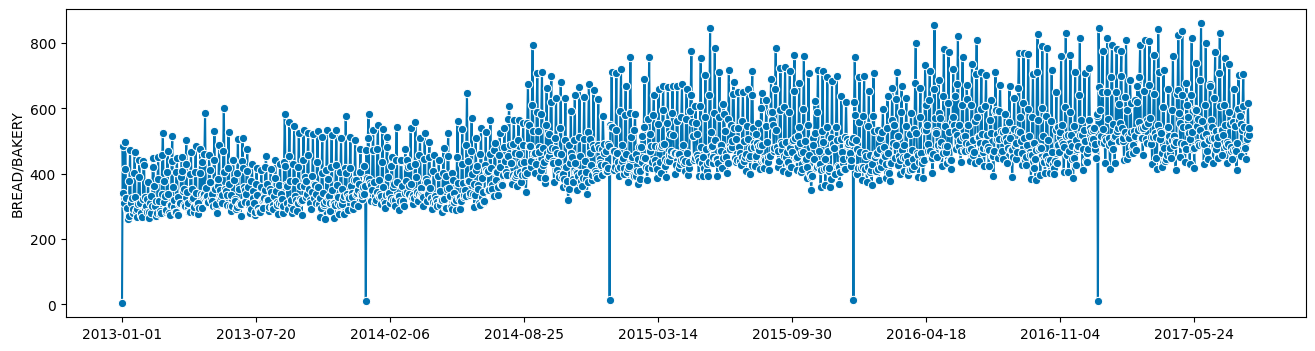

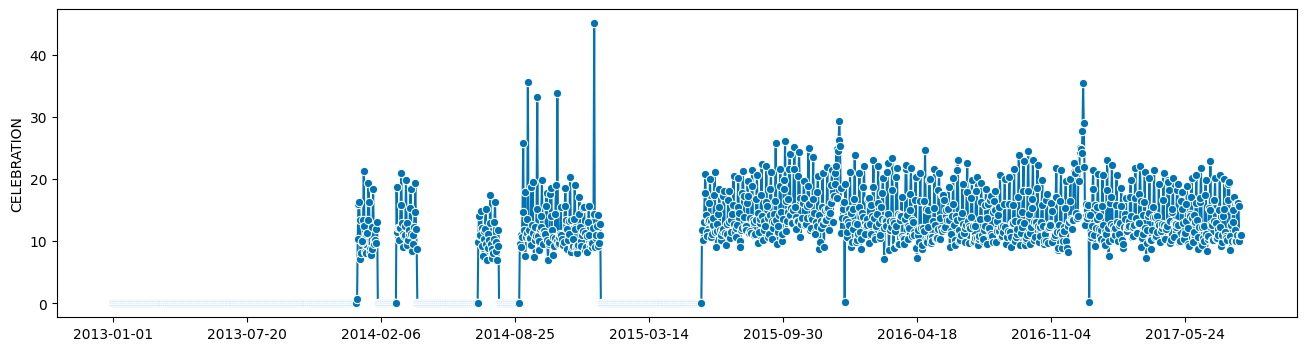

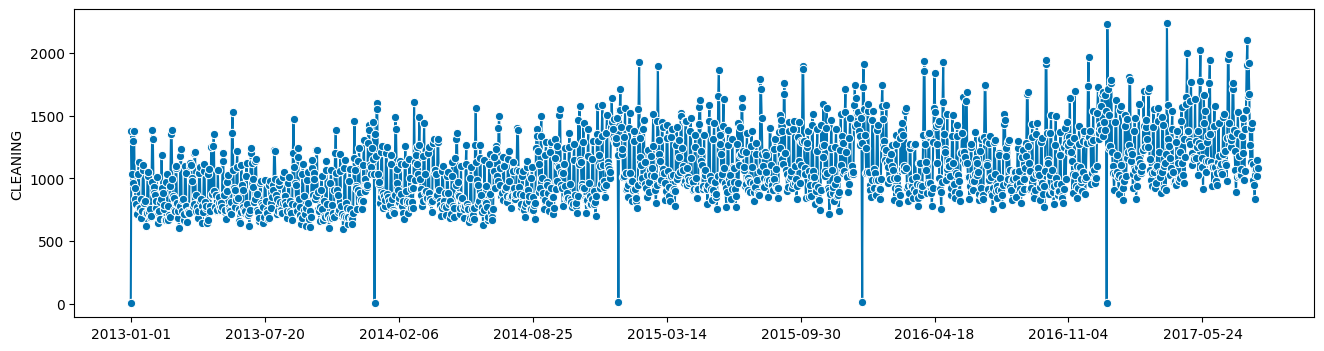

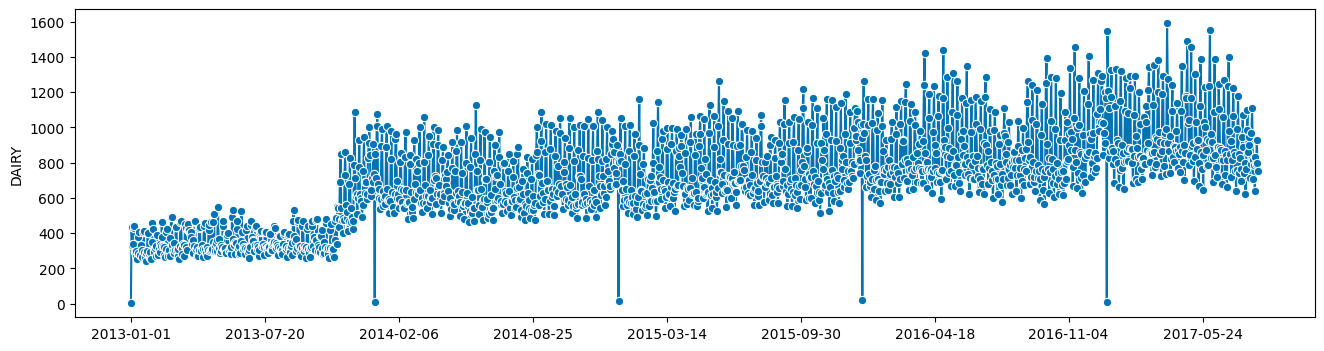

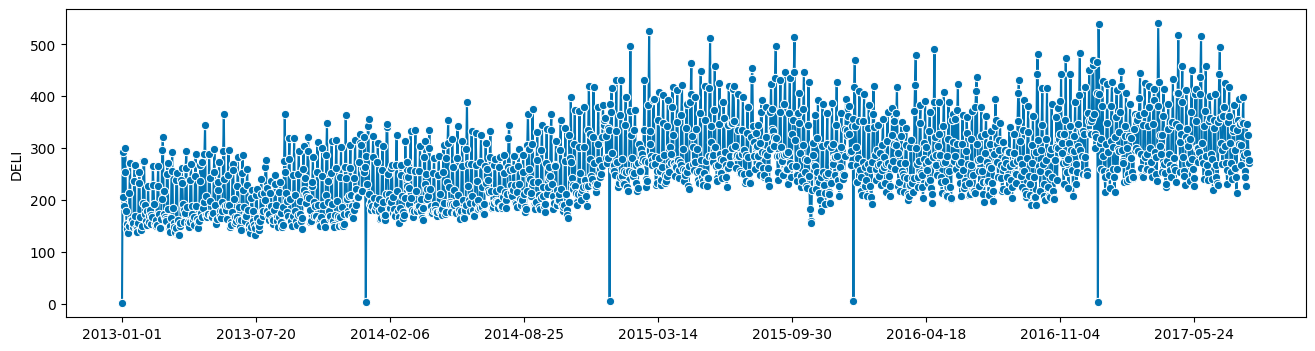

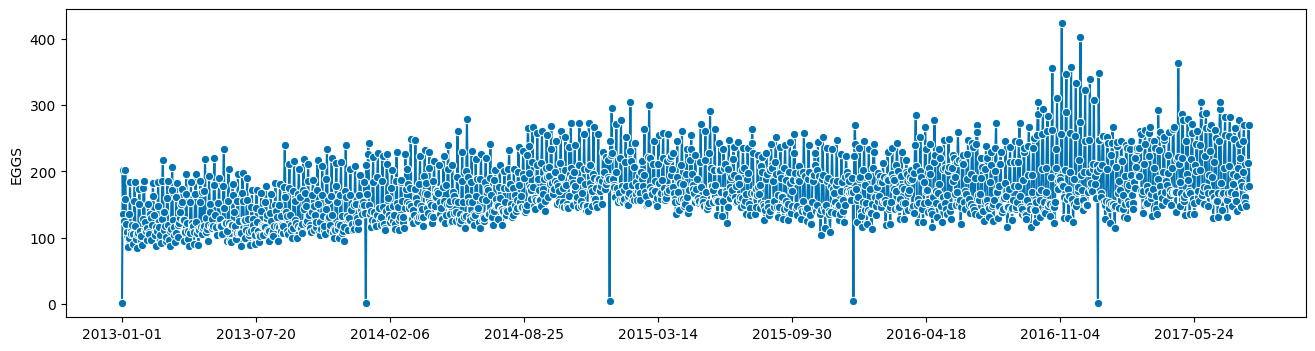

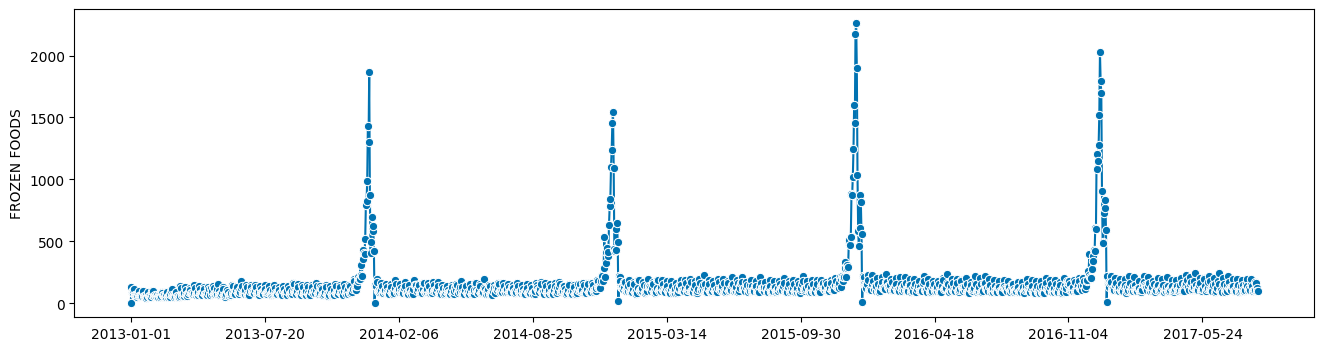

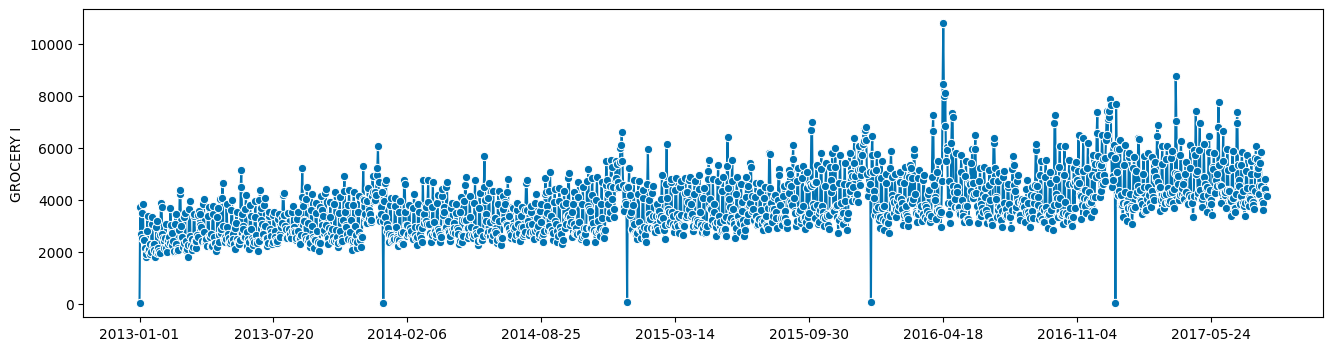

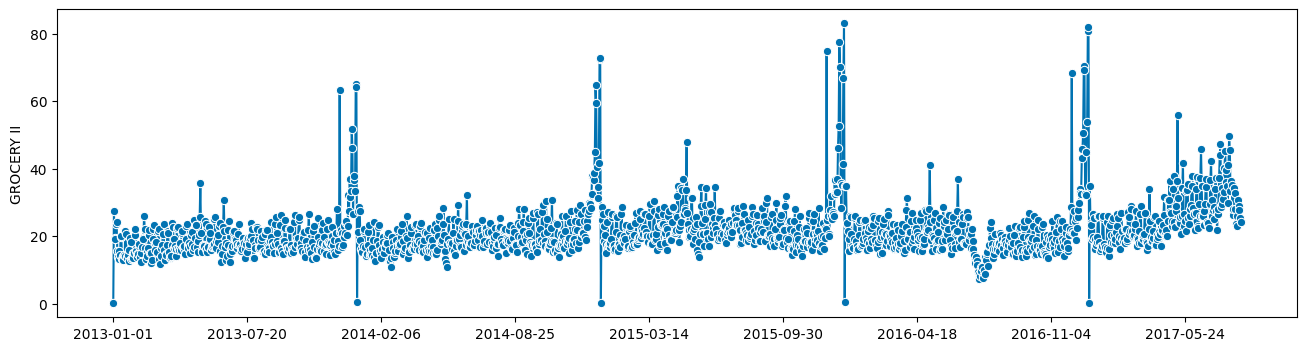

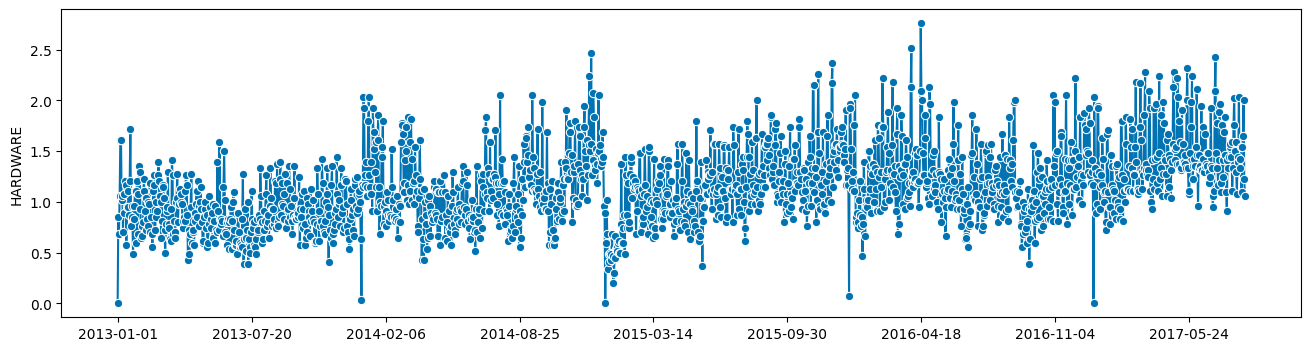

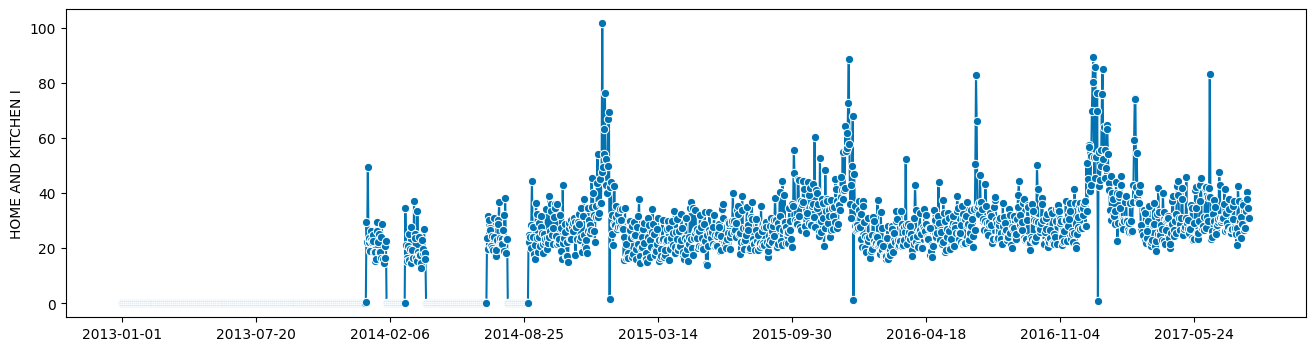

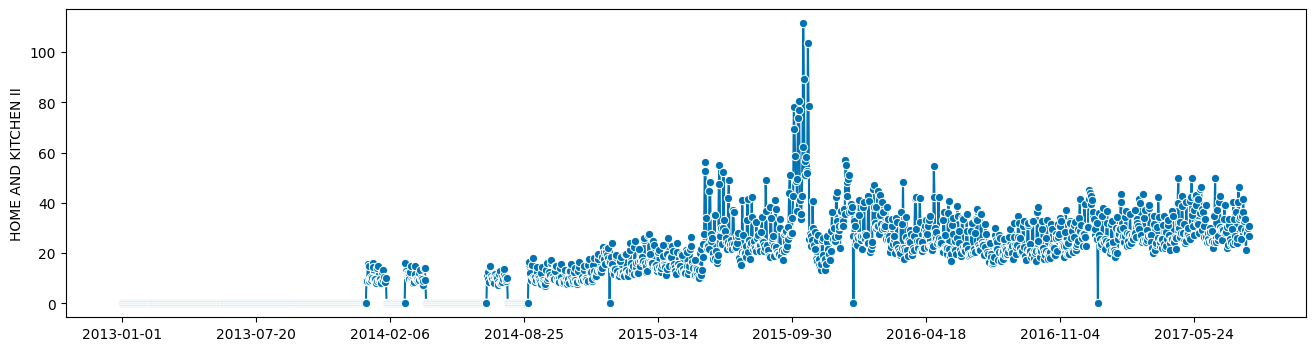

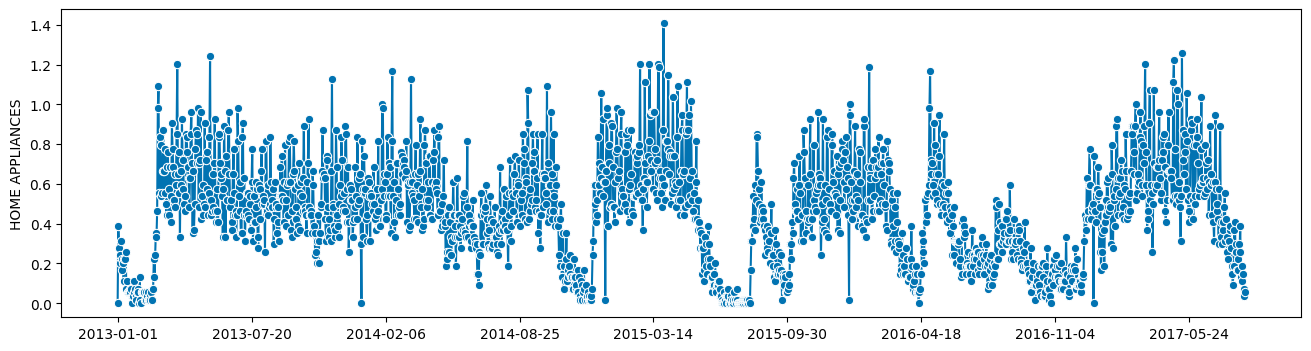

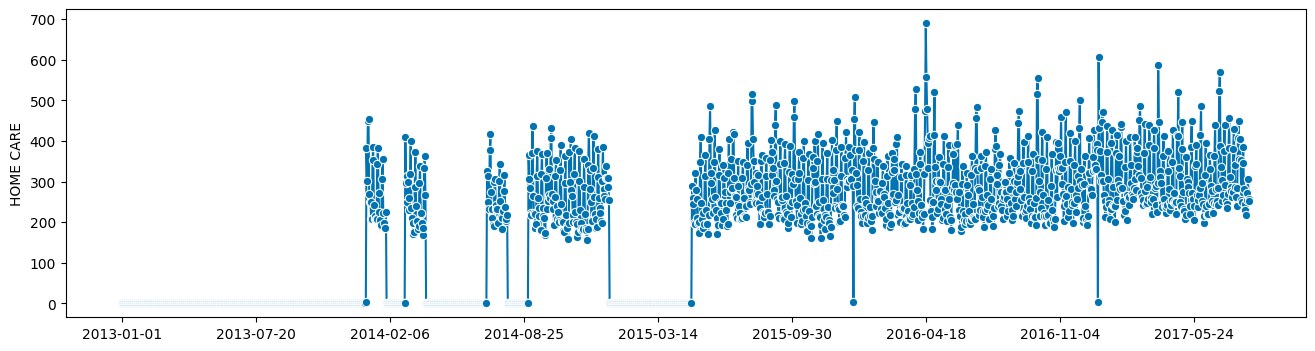

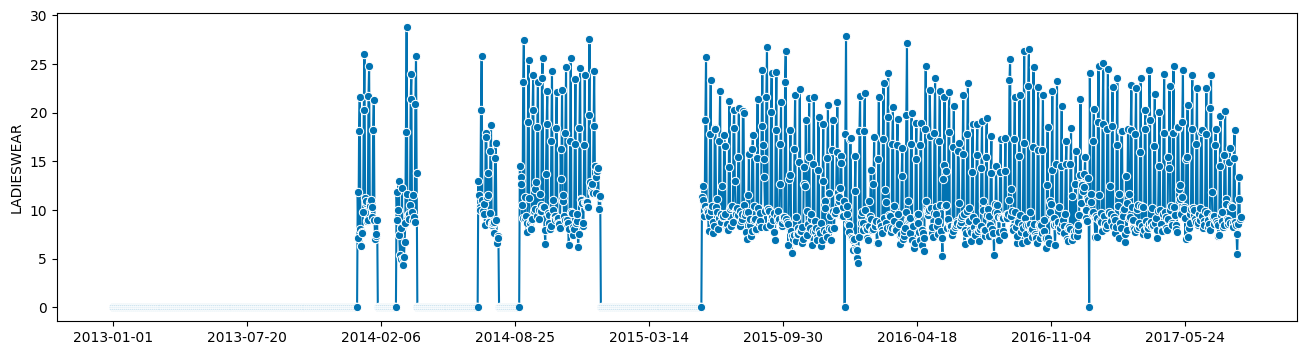

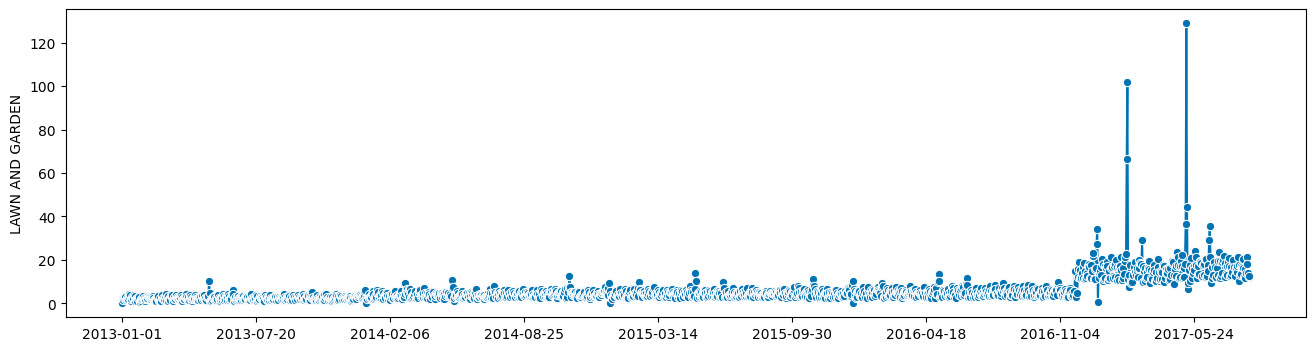

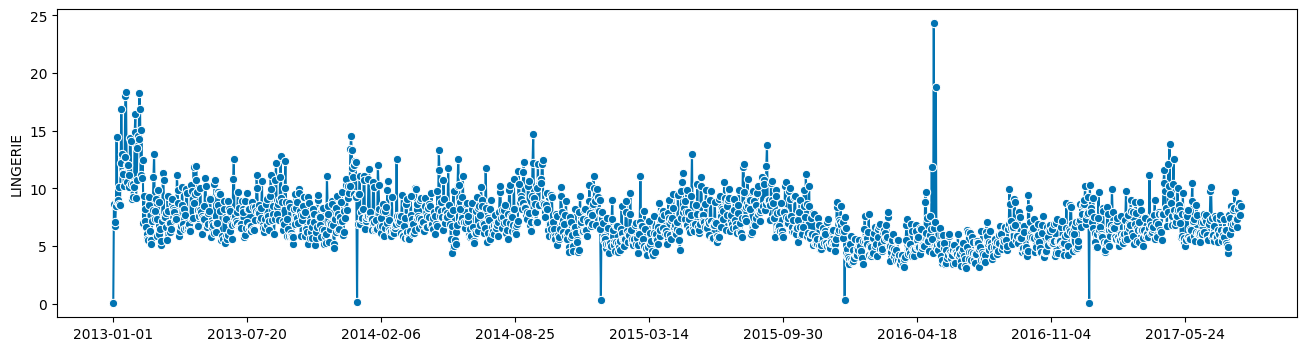

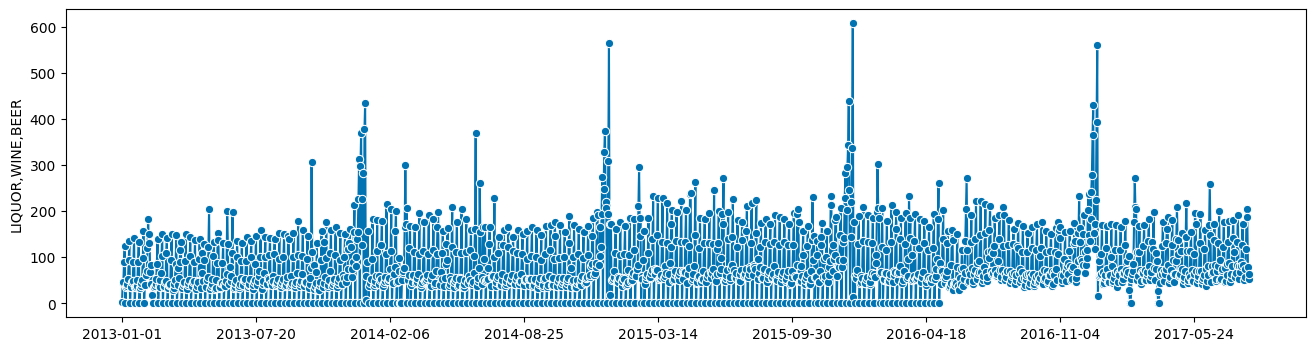

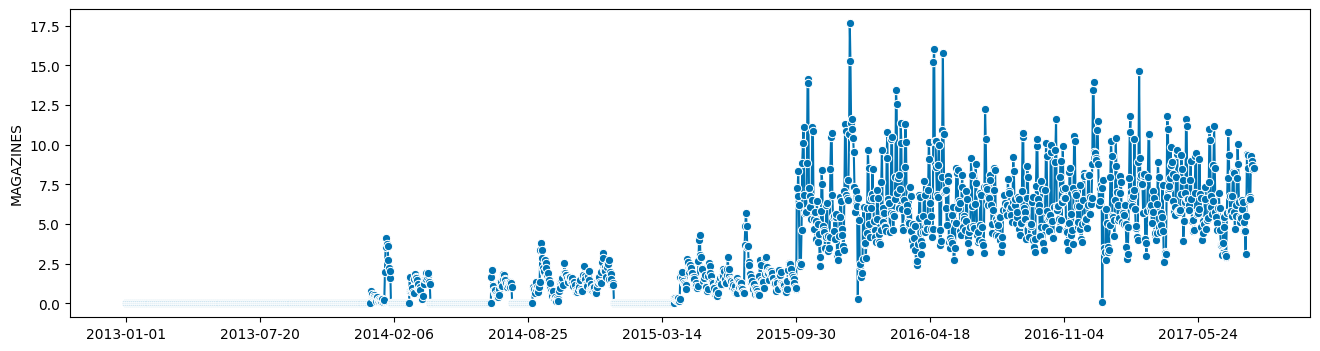

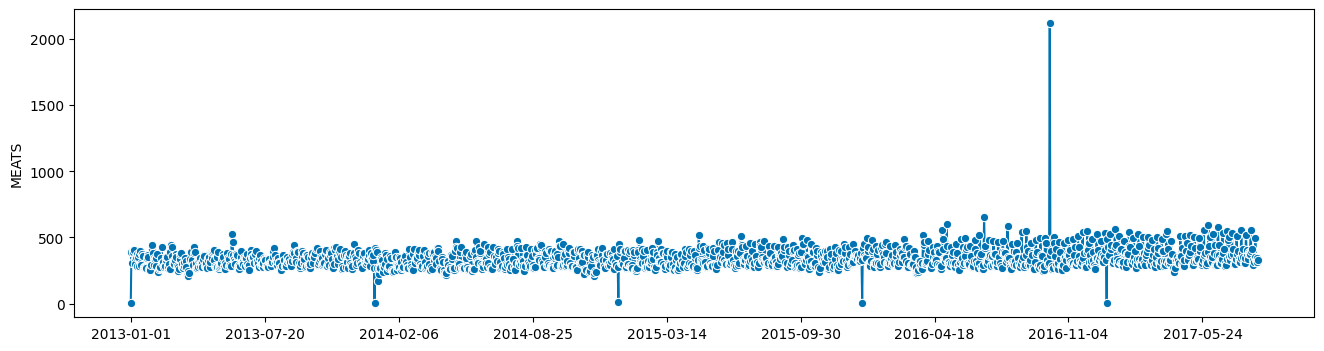

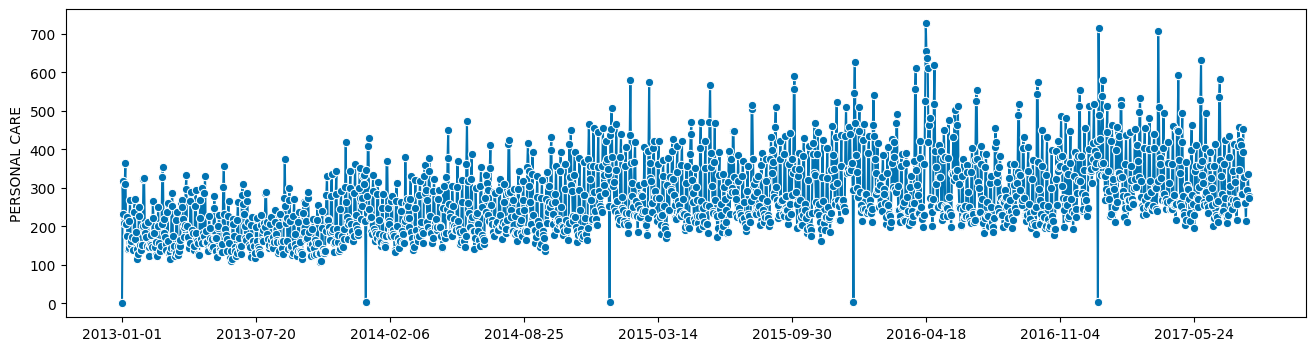

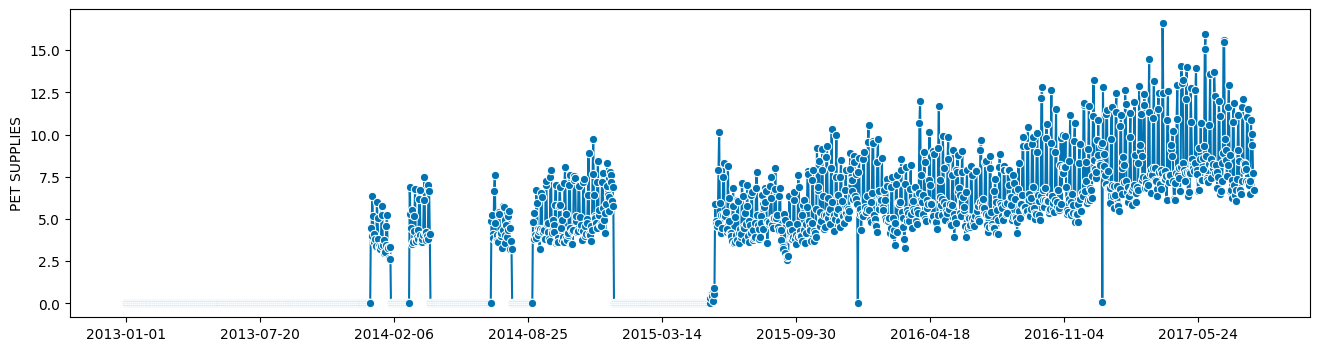

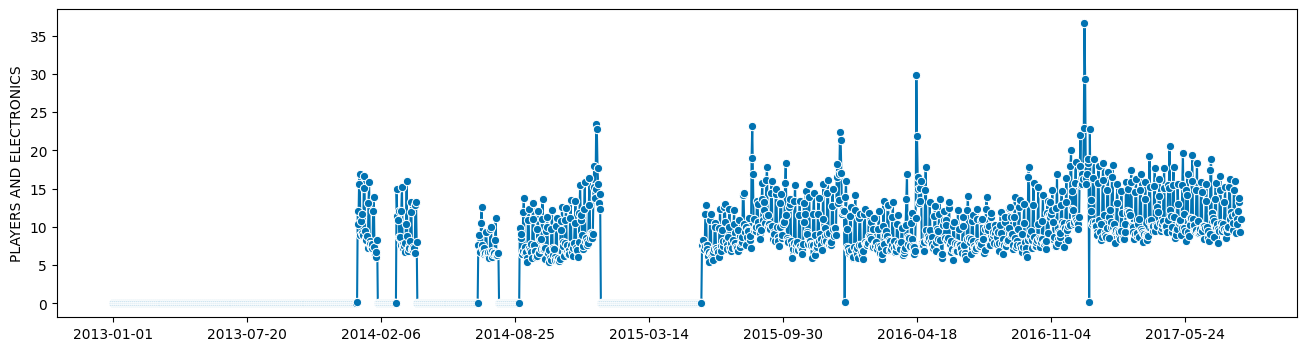

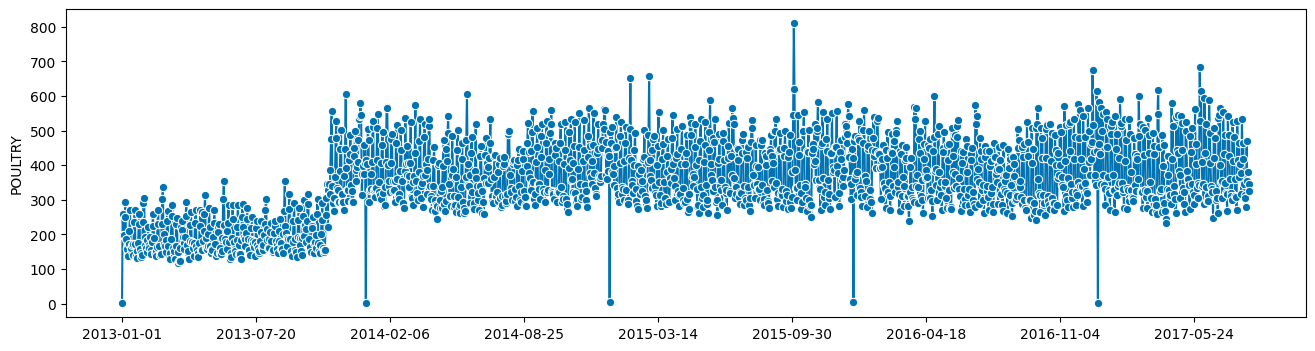

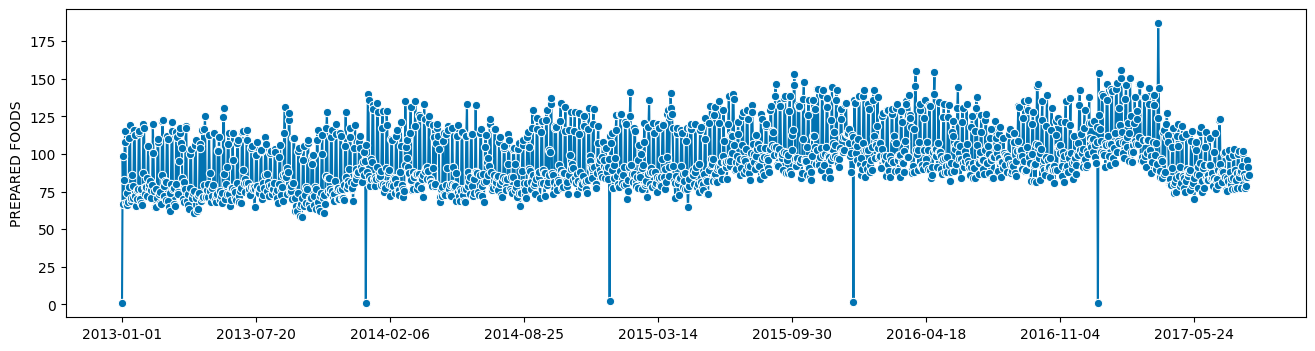

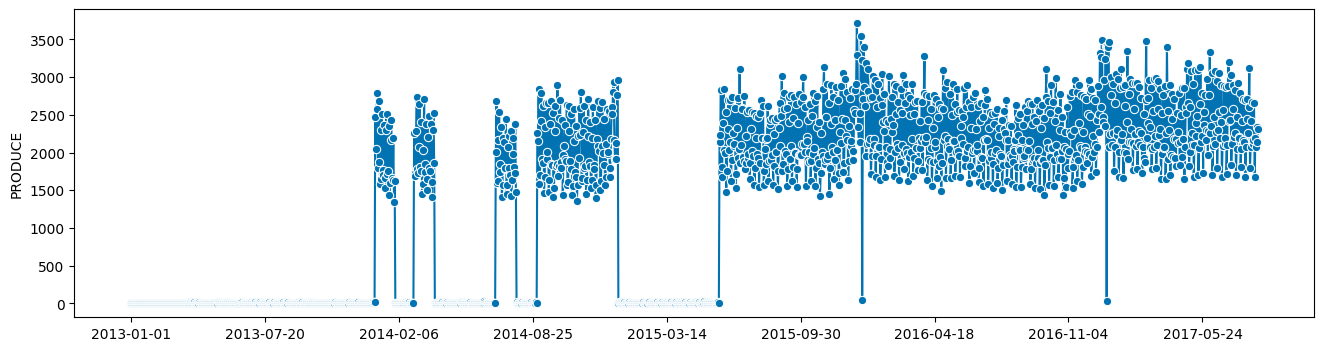

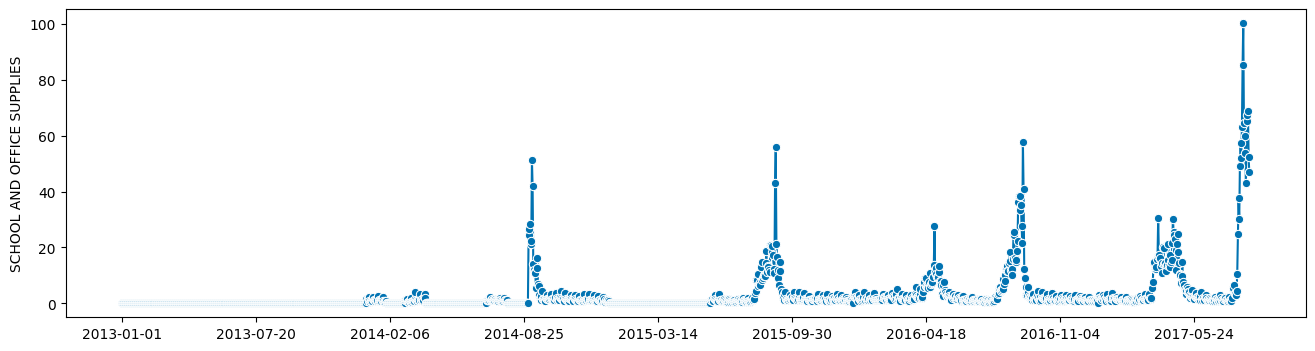

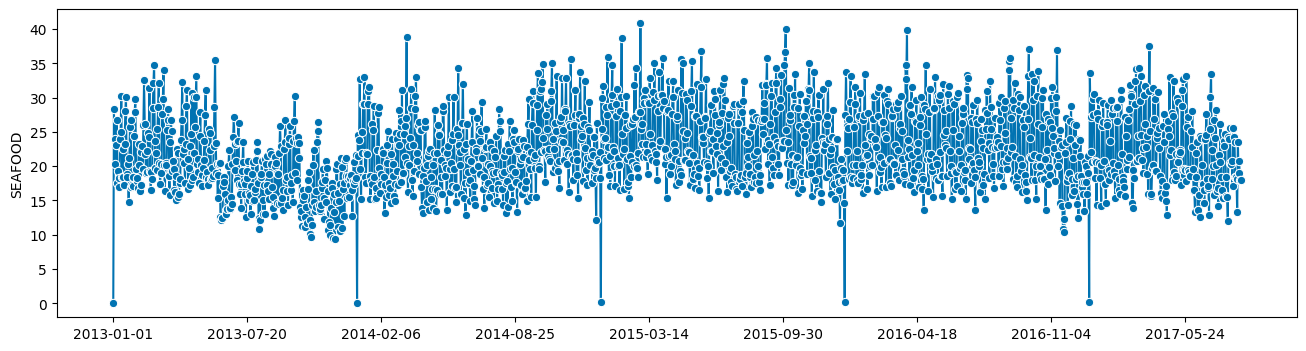

In [5]:
#lets plot out each family sales time series to take an initial look at the data
for col in df_family.sales.columns:
    plot_series(df_family.sales[col])

### Initial look at the target variable's time plots
We can see a few interesting things right away:
1) There is one day in every year that has 0 sales for all product families, this likely is a holiday where all stores are closed. It looks like it could be Christmas.
2) There are some product families that were likely not sold in stores until a certain date within the data
3) there are some product families with very large consecutive periods of zero sales that will be difficult to explain without specific domain knowledge
4) there are some very obvious single point outliers of extreme magnitude which are possibly the result of errors in the data, we can investigate this further.